<a href="https://colab.research.google.com/github/truffleToast/DeepLearning/blob/main/%EA%B3%B5%EC%A0%95_%ED%94%84%EB%A1%9C%EC%84%B8%EC%8A%A4_%EC%B5%9C%EC%A2%85_%ED%92%88%EC%A7%88%EA%B0%92_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt #그래프 그리기
from sklearn.linear_model import LinearRegression #선형분류
import statsmodels.graphics.tsaplots as sgt #  acf, pcaf 그리기
import seaborn as sns #heatmap 사용을 위해 import
import xgboost as xgb #xgb
import lightgbm as lgb #lgbm3
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor #RandomForest, GradinetBoosting
from sklearn.multioutput import MultiOutputRegressor # 다항 회귀
from sklearn.preprocessing import RobustScaler # 로버스트 스케일러
from sklearn.model_selection import KFold # Kfold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error #R2_score # mse, mae
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_df = pd.read_csv("./data/continuous_factory_process.csv", index_col ="time_stamp")
raw_sub =pd.read_csv("./data/submission_data.csv", index_col ="time_stamp")

In [ ]:
df = raw_df.drop(columns=[col for col in raw_df.columns if col.endswith('.Setpoint')]) #setPoint제거
sub = raw_sub.drop(columns=[col for col in raw_df.columns if col.endswith('.Setpoint')]) #setPoint제거

In [ ]:
#0~1번 인덱스 주변의 습도, 온도
#2~5번 RawMaterial 원본 재료 투입량
#6번 feeder -> 원본 재료를 가지고 작동하는 공식 , 2~5번의 데이터를 조합해서 어떻게 하겟다
#7~8 번 feeder를 가동하면 나오는 온도
#9 Motor의 전류
#10 Motor가 돌아가는 rpm
# 11. MaterialPressure는  2~5번에 가해지는 압력
# 12. MaterialTemperature는 재료의 온도
# 13. 출구온도
# 2~5번은 지속적으로 반복됨(Machine1,2,3에서)

# 마지막 콤바인 3개
#Machine 4,5에서는 온도와 압력만 관찰되는 양상
df.info()
# coef 상관계수가 관련이 크다면 온도가 4개가 나왓다면
# feature_importances
#xg_boost를 썻을때

<class 'pandas.core.frame.DataFrame'>
Index: 11270 entries, 2019-03-06 10:52:33 to 2019-03-06 14:47:20
Data columns (total 85 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   AmbientConditions.AmbientHumidity.U.Actual          11270 non-null  float64
 1   AmbientConditions.AmbientTemperature.U.Actual       11270 non-null  float64
 2   Machine1.RawMaterial.Property1                      11270 non-null  float64
 3   Machine1.RawMaterial.Property2                      11270 non-null  int64  
 4   Machine1.RawMaterial.Property3                      11270 non-null  float64
 5   Machine1.RawMaterial.Property4                      11270 non-null  int64  
 6   Machine1.RawMaterialFeederParameter.U.Actual        11270 non-null  float64
 7   Machine1.Zone1Temperature.C.Actual                  11270 non-null  float64
 8   Machine1.Zone2Temperature.C.Actual               

In [ ]:
X1 = df.iloc[:,:41]
Rx1 = sub.iloc[:,:41]
y1 = df.iloc[:,41:56]
X2 = df.iloc[:,56:70]
Rx2 =sub.iloc[:,56:70]
y2 = df.iloc[:,70:]

# 평균 내서 편하게 상관관계

In [ ]:
mean_y1 = y1.mean(axis =1)
py1= pd.DataFrame(mean_y1)
py1.columns = ['Mean']
py1

,Mean
time_stamp,
2019-03-06 10:52:33,8.279333
2019-03-06 10:52:38,6.619333
2019-03-06 10:52:40,8.208667
2019-03-06 10:52:42,5.537333
2019-03-06 10:52:43,3.654667
...,...
2019-03-06 14:47:13,9.058000
2019-03-06 14:47:16,8.812667
2019-03-06 14:47:17,8.812667


In [ ]:
mean_y2 = y2.mean(axis =1)
py2= pd.DataFrame(mean_y2)
py2.columns = ['Mean']
py2

,Mean
time_stamp,
2019-03-06 10:52:33,0.000000
2019-03-06 10:52:38,0.000000
2019-03-06 10:52:40,0.000000
2019-03-06 10:52:42,0.000000
2019-03-06 10:52:43,0.000000
...,...
2019-03-06 14:47:13,6.406667
2019-03-06 14:47:16,6.835333
2019-03-06 14:47:17,6.796667


# 데이터 상관관계 확인

In [ ]:
a = pd.concat([X1, py1], axis=1)
b = pd.concat([X2, py2], axis=1)

<AxesSubplot:>

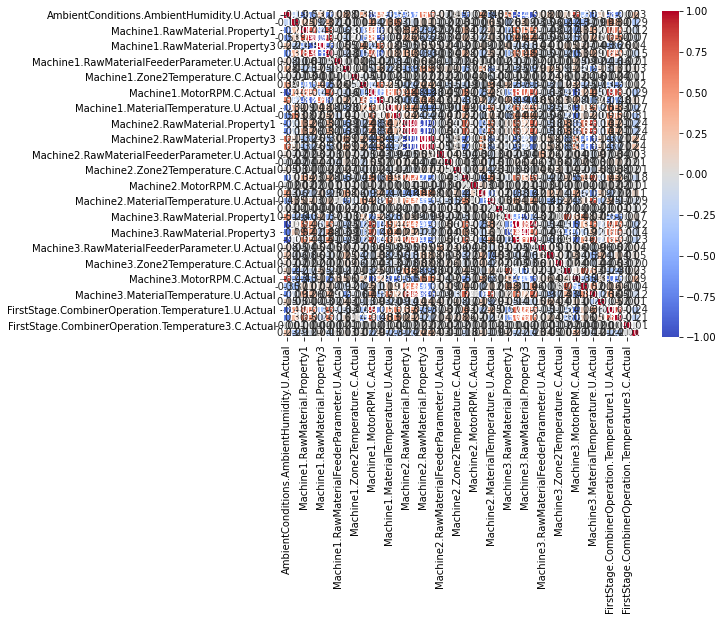

In [ ]:
plt.figure(figsize=(8, 6))  # 그림 크기 조절 (선택사항)
sns.heatmap(a.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

<AxesSubplot:>

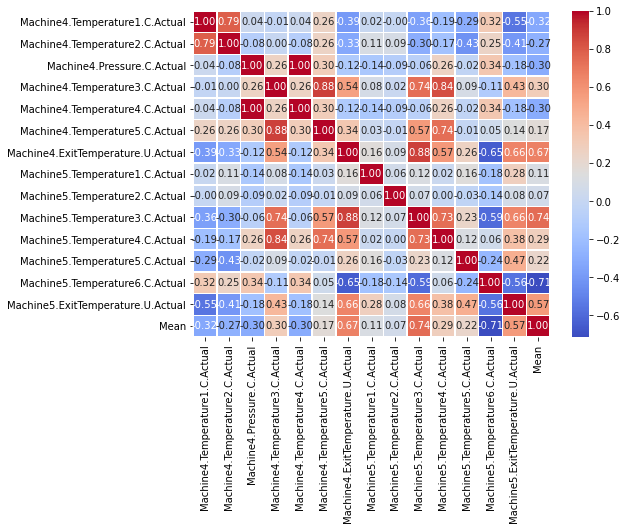

In [ ]:
plt.figure(figsize=(8, 6))  # 그림 크기 조절 (선택사항)
sns.heatmap(b.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

In [ ]:
# 각 feature와 'Mean' 사이의 상관계수를 계산
correlation_with_mean = a.corrwith(a['Mean']).drop('Mean')

# 상관계수를 절대값 기준으로 내림차순 정렬
sorted_correlation_with_mean = correlation_with_mean.abs().sort_values(ascending=False)

# 유의미한 상관계수를 가진 feature만 선택
heatmapX1 = sorted_correlation_with_mean[sorted_correlation_with_mean > 0.05].index.tolist()
sorted_correlation_with_mean, heatmapX1

(Machine1.ExitZoneTemperature.C.Actual                 0.306309
 AmbientConditions.AmbientTemperature.U.Actual         0.293600
 Machine1.MotorRPM.C.Actual                            0.289938
 Machine3.MotorRPM.C.Actual                            0.288466
 Machine1.MaterialTemperature.U.Actual                 0.266884
 FirstStage.CombinerOperation.Temperature1.U.Actual    0.236770
 Machine2.RawMaterial.Property1                        0.236177
 Machine2.RawMaterial.Property3                        0.236177
 Machine2.RawMaterial.Property2                        0.236177
 Machine2.RawMaterial.Property4                        0.236177
 AmbientConditions.AmbientHumidity.U.Actual            0.234162
 Machine3.RawMaterial.Property4                        0.232059
 Machine3.RawMaterial.Property2                        0.220689
 FirstStage.CombinerOperation.Temperature2.U.Actual    0.205792
 Machine2.MotorAmperage.U.Actual                       0.177666
 Machine1.RawMaterial.Property4         

In [ ]:
# 각 feature와 'Mean' 사이의 상관계수를 계산
correlation_with_mean = b.corrwith(b['Mean']).drop('Mean')

# 상관계수를 절대값 기준으로 내림차순 정렬
sorted_correlation_with_mean = correlation_with_mean.abs().sort_values(ascending=False)

# 유의미한 상관계수를 가진 feature만 선택
heatmapX2 = sorted_correlation_with_mean[sorted_correlation_with_mean > 0.05].index.tolist()
sorted_correlation_with_mean, heatmapX2

(Machine5.Temperature3.C.Actual       0.740297
 Machine5.Temperature6.C.Actual       0.713731
 Machine4.ExitTemperature.U.Actual    0.666665
 Machine5.ExitTemperature.U.Actual    0.568469
 Machine4.Temperature1.C.Actual       0.323936
 Machine4.Pressure.C.Actual           0.302047
 Machine4.Temperature4.C.Actual       0.302047
 Machine4.Temperature3.C.Actual       0.298211
 Machine5.Temperature4.C.Actual       0.285552
 Machine4.Temperature2.C.Actual       0.272453
 Machine5.Temperature5.C.Actual       0.223511
 Machine4.Temperature5.C.Actual       0.172937
 Machine5.Temperature1.C.Actual       0.113391
 Machine5.Temperature2.C.Actual       0.066119
 dtype: float64,
 ['Machine5.Temperature3.C.Actual',
  'Machine5.Temperature6.C.Actual',
  'Machine4.ExitTemperature.U.Actual',
  'Machine5.ExitTemperature.U.Actual',
  'Machine4.Temperature1.C.Actual',
  'Machine4.Pressure.C.Actual',
  'Machine4.Temperature4.C.Actual',
  'Machine4.Temperature3.C.Actual',
  'Machine5.Temperature4.C.Actual',

### 1. 스케일링 없이 진행

### LightGbm 모델

In [ ]:
# LightGBM 모델 설정
lgb_model = lgb.LGBMRegressor(objective='regression')  # 회귀 모델 설정
multi =MultiOutputRegressor(lgb_model) # 멀티 아웃풋 사용
# 데이터를 학습 및 검증 세트로 분할
filteredX1 = df[heatmapX1]
filteredX2= df[heatmapX2]
train_X1, val_X1, train_Y1, val_Y1 = train_test_split(filteredX1, y1, test_size = 0.2 , random_state =152)
train_X2, val_X2, train_Y2, val_Y2 = train_test_split(filteredX2, y2, test_size = 0.2 , random_state =152)

# 모델1

In [ ]:
# 모델학습
multi.fit(train_X1,train_Y1)
#모델 예측
pred1 = multi.predict(val_X1)
# 모델 평가
mae = mean_absolute_error(val_Y1, pred1)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.5163870252365366


#  모델 1 교차검증

In [ ]:
# 모델과 데이터 준비
lgb_model = lgb.LGBMRegressor(objective='regression')  # LightGBM 모델 설정
multi =MultiOutputRegressor(lgb_model) # 멀티 아웃풋 사용
# K-fold 교차 검증 수행 (K=5로 가정)
k = 5
scores = cross_val_score(multi, train_X1, train_Y1, cv=k, scoring='neg_mean_absolute_error')
mae_scores = -scores  # scores는 음수 MAE 값이므로 양수로 변환
mean_mae = mae_scores.mean()
print("Mean Absolute Error (MAE) for K-fold Cross-Validation:", mean_mae)

Mean Absolute Error (MAE) for K-fold Cross-Validation: 0.529085864881381


In [ ]:
# 각 출력(추정자)에 대한 특성 중요도를 저장할 리스트
output_feature_importances = []

# 각 출력(추정자)에 대한 특성 중요도를 계산하고 저장
for model in multi.estimators_:
    feature_importance = model.feature_importances_
    output_feature_importances.append(feature_importance)

# 각 출력(추정자)의 특성 중요도를 출력
for output_index, feature_importance in enumerate(output_feature_importances):
    print(f"Output {output_index + 1} Feature Importance:")
    for feature_index, importance in enumerate(feature_importance):
        print(f"Feature {X1.columns[feature_index]}: {importance}")
    print()

# 각 특성의 중요도를 열별로 더한 후 평균 계산
average_feature_importance = np.mean(output_feature_importances, axis=0)

# 각 특성의 평균 중요도 출력
print("Average Feature Importance:")
for feature_index, importance in enumerate(average_feature_importance):
    print(f"Feature {X1.columns[feature_index]}: {importance}")

Output 1 Feature Importance:
Feature AmbientConditions.AmbientHumidity.U.Actual: 80
Feature AmbientConditions.AmbientTemperature.U.Actual: 100
Feature Machine1.RawMaterial.Property1: 67
Feature Machine1.RawMaterial.Property2: 308
Feature Machine1.RawMaterial.Property3: 148
Feature Machine1.RawMaterial.Property4: 479
Feature Machine1.RawMaterialFeederParameter.U.Actual: 0
Feature Machine1.Zone1Temperature.C.Actual: 5
Feature Machine1.Zone2Temperature.C.Actual: 0
Feature Machine1.MotorAmperage.U.Actual: 0
Feature Machine1.MotorRPM.C.Actual: 41
Feature Machine1.MaterialPressure.U.Actual: 59
Feature Machine1.MaterialTemperature.U.Actual: 0
Feature Machine1.ExitZoneTemperature.C.Actual: 491
Feature Machine2.RawMaterial.Property1: 133
Feature Machine2.RawMaterial.Property2: 0
Feature Machine2.RawMaterial.Property3: 23
Feature Machine2.RawMaterial.Property4: 0
Feature Machine2.RawMaterialFeederParameter.U.Actual: 471
Feature Machine2.Zone1Temperature.C.Actual: 226
Feature Machine2.Zone2Temper

# 모델2

In [ ]:
#변수 불러오기
train_X21 =pd.DataFrame(Stage0)
train_X21.index = df.index
train_X22 =df[Stage2_Features]
train_X2 = pd.concat([train_X21, train_X22],axis = 1)
train_y2 = y2
testX21 = Stage1
testX22 = sub[Stage2_Features]
testX2 =np.concatenate([Stage1, testX22.values], axis =1)
# 모델설정
# LightGBM 모델 설정
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=10)  # 회귀 모델 설정
multi =MultiOutputRegressor(lgb_model) # 멀티 아웃풋 사용
# 모델학습
multi.fit(train_X2.values, train_y2.values)
#모델 예측
Stage2 = multi.predict(testX2)

### 2.  데이터 전처리 후 스케일링

### 2. RobustScaling

### Robust 스케일링은 문제데이터에서 FIT_TRANSFORM, SUB 에서 TRANSFROM 적용

###  단 ambient, firstx1, secondx2에만 적용시켜야 하고
### sub에서도 RAmbient, RfirstX1 , RSecondX2 만 transform 해야함


# 모델2

## LightGBM

## 모델 1

In [ ]:
# RobustScaler 객체 생성
scaler = RobustScaler()

sX1 =scaler.fit_transform(X1)
sRx1 = scaler.transform(RX1)

# LightGBM 모델 설정
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=10 ,cv = 5)  # 회귀 모델 설정
multi =MultiOutputRegressor(lgb_model) # 멀티 아웃풋 사용

# 모델학습
multi.fit(sX1, y1)
#모델 예측
Stage0 =multi.predict(sX1)

In [ ]:
Stage1 =multi.predict(sRx1)

Stage0.shape

Stage1.shape

finalpredX = np.concatenate([Stage0,X22.values],axis =1) #Stage 0은 내가 예측한 값으로 학습
finalX = pd.concat([y1,X22],axis =1) # 실제값으로 학습

RfinalX = np.concatenate([Stage1,RX22.values],axis =1)

# LightGBM 모델 설정
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=10)  # 회귀 모델 설정
multi2 =MultiOutputRegressor(lgb_model) # 멀티 아웃풋 사용

scaler = RobustScaler() # 로버스트 스케일러 초기화

sfinalpredX =scaler.fit_transform(finalpredX)
sRfinalX =scaler.transform(RfinalX)
scaler = RobustScaler()
# sfinalX=scaler.fit_transform(finalX)


multi2.fit(sfinalpredX, y2)

Stage2 =multi2.predict(sRfinalX)

np.save('submission1.npy', Stage1)
np.save('submission2.npy', Stage2)

# 제출 및 채점

아래 코드를 수정하면 정상적인 채점을 수행할 수 없습니다.

In [ ]:
import sys
sys.path.append('vendor')
from elice_challenge import check_score, upload
# 제출 파일 업로드
await upload()

# 채점 수행
await check_score()

이메일 > rudals7841@naver.com
비밀번호 > ········
이전에 업로드 된 파일 삭제중...
업로드가 완료되었습니다.
점수는 64.988661 점 입니다.
